# Proyek Klasifikasi Gambar: [cars-image-dataset]
- **Nama:** [Naia Shaffa Camila]
- **Email:** [naiashaffa@gmail.com]
- **ID Dicoding:** [MC015D5X2145]

## Import Semua Packages/Library yang Digunakan

In [1]:
# Mengimpor libraries umum yang sering digunakan
import os, shutil
import zipfile
import random
from random import sample
import shutil
from shutil import copyfile
import pathlib
from pathlib import Path
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm as tq

# Mengimpor libraries untuk visualisasi
%matplotlib inline
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.image import imread

# Mengimpor libraries untuk pemrosesan data gambar
import cv2
from PIL import Image
import skimage
from skimage import io
from skimage.transform import resize
from skimage.transform import rotate, AffineTransform, warp
from skimage import img_as_ubyte
from skimage.exposure import adjust_gamma
from skimage.util import random_noise

# Mengimpor libraries untuk pembuatan dan evaluasi model
import keras
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
from tensorflow.keras import Model, layers
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.layers import InputLayer, Conv2D, SeparableConv2D, MaxPooling2D, MaxPool2D, Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.applications import MobileNet, InceptionV3, Xception
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, Callback, EarlyStopping, ReduceLROnPlateau

# Mengabaikan peringatan
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
print(tf.__version__)

2.18.0


## Data Preparation

### Data Loading

In [3]:
# Import module yang disediakan google colab untuk kebutuhan upload file
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"naiashaffa","key":"48518bc17b22cd6689dc973150980c35"}'}

In [4]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [5]:
!kaggle datasets download -d kshitij192/cars-image-dataset

Dataset URL: https://www.kaggle.com/datasets/kshitij192/cars-image-dataset
License(s): GPL-2.0


In [6]:
!unzip cars-image-dataset.zip -d dataset

Archive:  cars-image-dataset.zip
  inflating: dataset/Cars Dataset/test/Audi/1000.jpg  
  inflating: dataset/Cars Dataset/test/Audi/1003.jpg  
  inflating: dataset/Cars Dataset/test/Audi/1008.jpg  
  inflating: dataset/Cars Dataset/test/Audi/1020.jpg  
  inflating: dataset/Cars Dataset/test/Audi/1022.jpg  
  inflating: dataset/Cars Dataset/test/Audi/1025.jpg  
  inflating: dataset/Cars Dataset/test/Audi/1027.jpg  
  inflating: dataset/Cars Dataset/test/Audi/1038.jpg  
  inflating: dataset/Cars Dataset/test/Audi/104.jpg  
  inflating: dataset/Cars Dataset/test/Audi/1043.jpg  
  inflating: dataset/Cars Dataset/test/Audi/1051.jpg  
  inflating: dataset/Cars Dataset/test/Audi/1059.jpg  
  inflating: dataset/Cars Dataset/test/Audi/1060.jpg  
  inflating: dataset/Cars Dataset/test/Audi/1064.jpg  
  inflating: dataset/Cars Dataset/test/Audi/1066.jpg  
  inflating: dataset/Cars Dataset/test/Audi/1072.jpg  
  inflating: dataset/Cars Dataset/test/Audi/1073.jpg  
  inflating: dataset/Cars Dataset

In [7]:
# mengabungkan file yang terpisah
train_dir = '/content/dataset/Cars Dataset/train'
test_dir = '/content/dataset/Cars Dataset/test'

# Path folder tujuan gabungan
combined_dir = '/content/dataset/combined_dataset'

# Buat folder tujuan jika belum ada
os.makedirs(combined_dir, exist_ok=True)

# Gabungkan file dari train dan val
for split_dir in [train_dir, test_dir]:
    for class_name in os.listdir(split_dir):
        class_path = os.path.join(split_dir, class_name)
        if os.path.isdir(class_path):
            target_class_dir = os.path.join(combined_dir, class_name)
            os.makedirs(target_class_dir, exist_ok=True)
            for filename in os.listdir(class_path):
                src_file = os.path.join(class_path, filename)
                # Tambahkan prefix agar tidak ada overwrite
                new_filename = f"{os.path.basename(split_dir)}_{filename}"
                dst_file = os.path.join(target_class_dir, new_filename)
                shutil.copy2(src_file, dst_file)

In [8]:
data_dir = '/content/dataset/combined_dataset'

class_distribution = {}
for class_name in os.listdir(data_dir):
  class_path = os.path.join(data_dir, class_name)
  if os.path.isdir(class_path):
    num_images = len(os.listdir(class_path))
    class_distribution[class_name] = num_images

for class_name, count in class_distribution.items():
  print(f"📂 Kelas '{class_name}' memiliki {count} gambar")

📂 Kelas 'Tata Safari' memiliki 547 gambar
📂 Kelas 'Swift' memiliki 526 gambar
📂 Kelas 'Mahindra Scorpio' memiliki 391 gambar
📂 Kelas 'Audi' memiliki 1013 gambar
📂 Kelas 'Hyundai Creta' memiliki 338 gambar
📂 Kelas 'Rolls Royce' memiliki 385 gambar
📂 Kelas 'Toyota Innova' memiliki 965 gambar


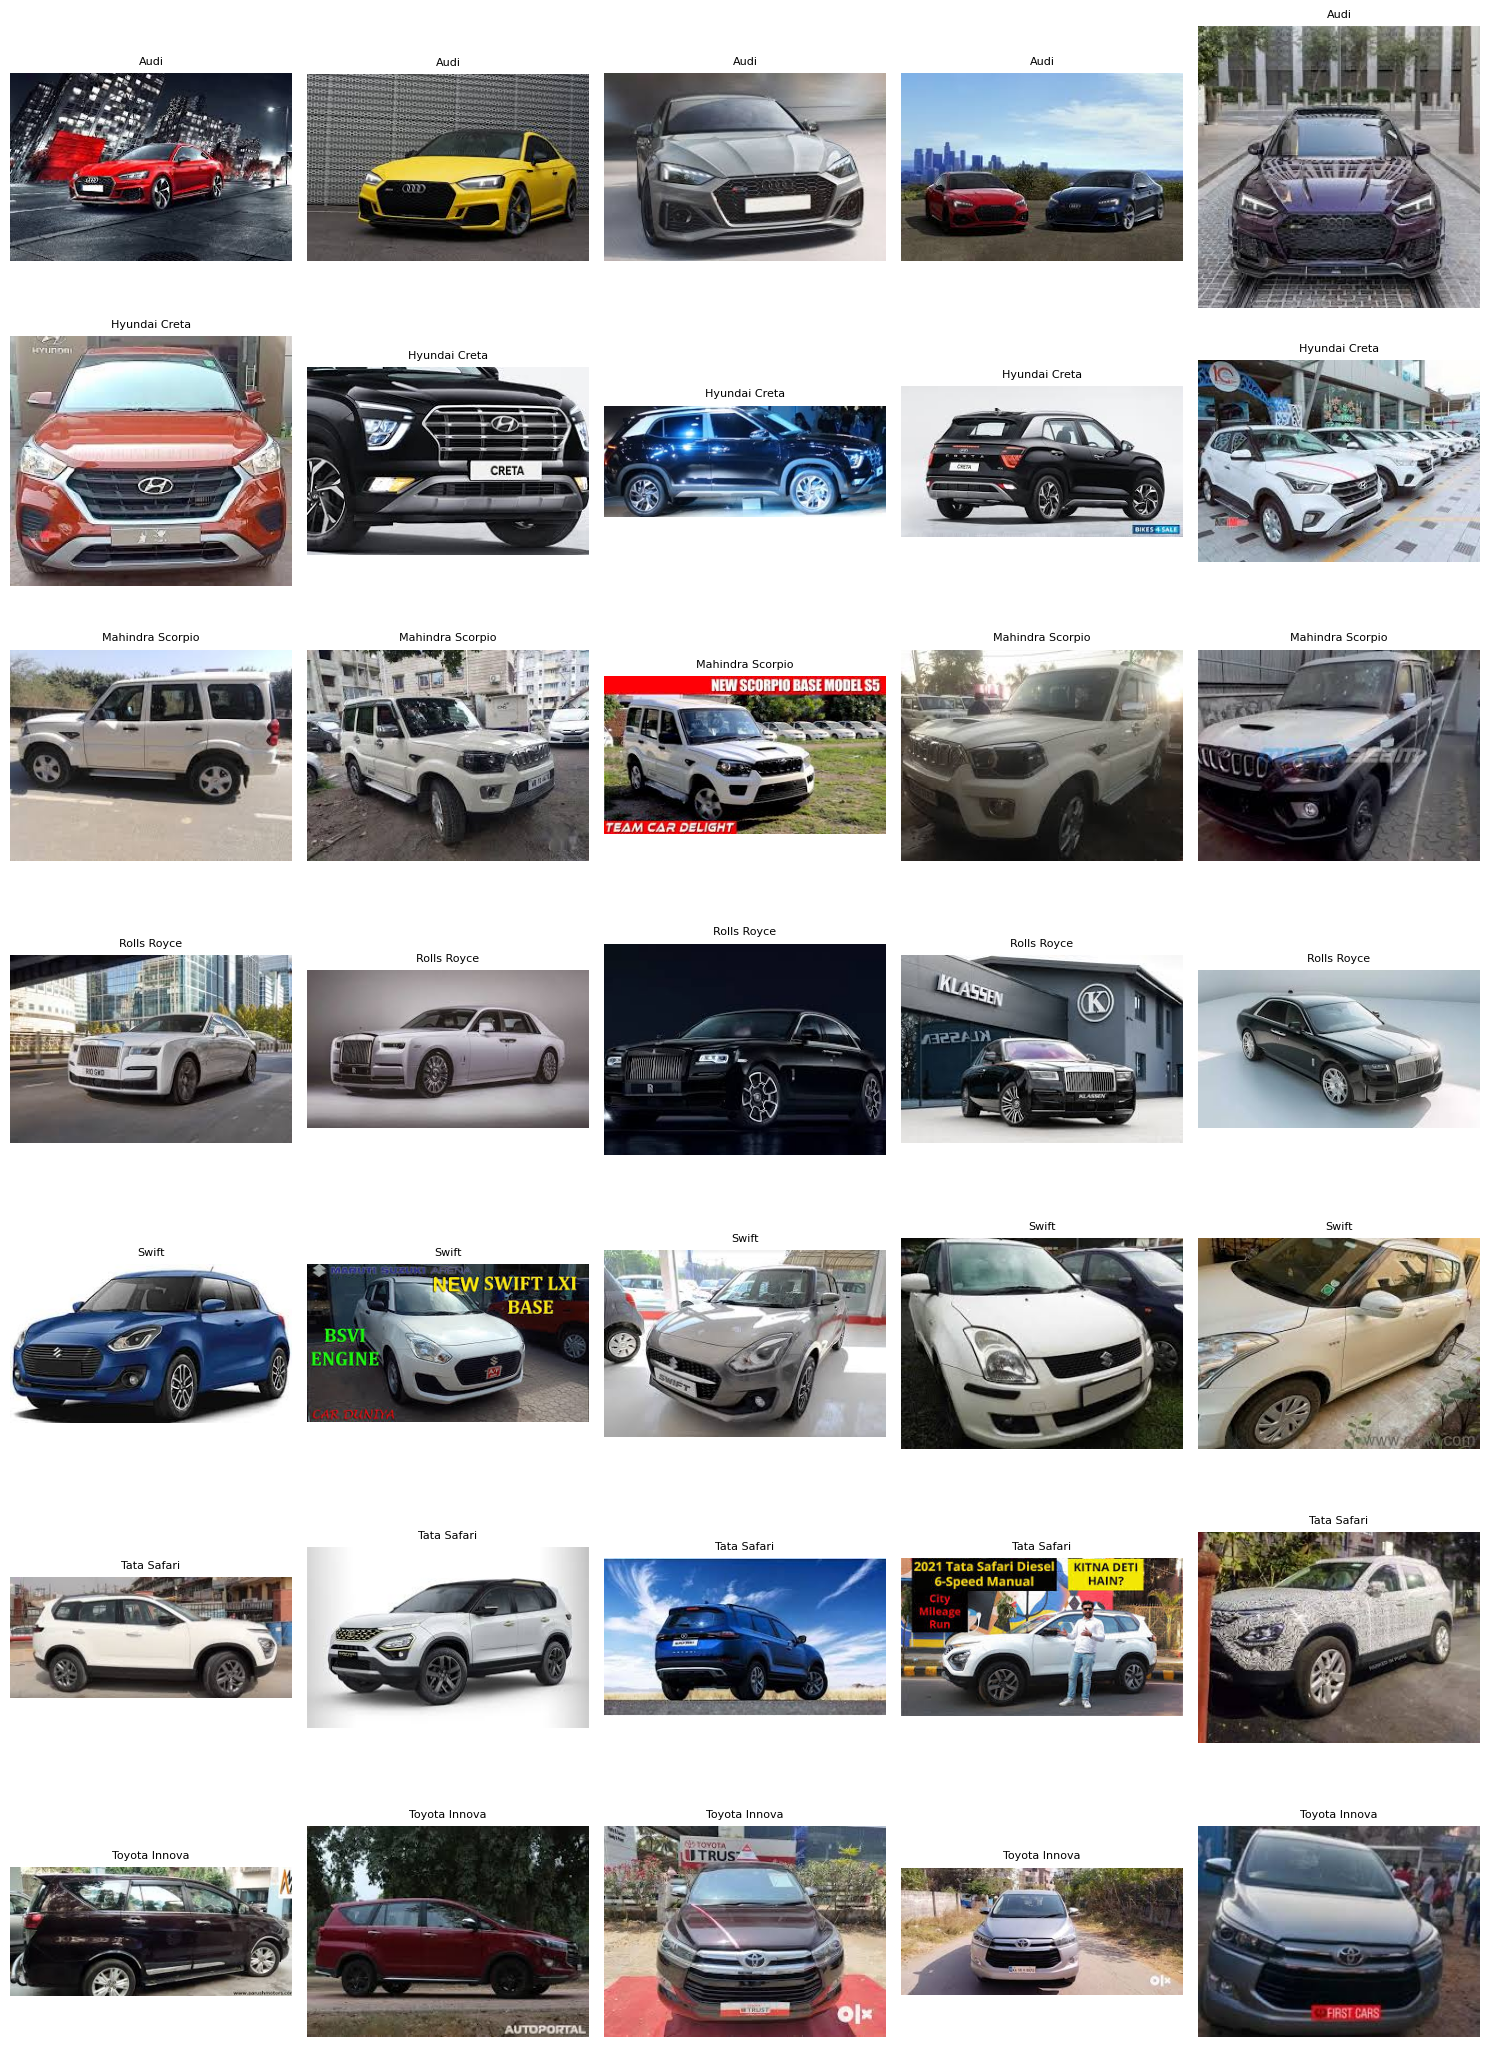

In [9]:
path = "/content/dataset/combined_dataset"

classes = sorted(os.listdir(path))
fig, axs = plt.subplots(len(classes), 5, figsize=(15, 3 * len(classes)))

for i, class_name in enumerate(classes):
    class_path = os.path.join(path, class_name)
    image_files = sorted(os.listdir(class_path))[:5]

    for j in range(5):
        img_path = os.path.join(class_path, image_files[j])
        img = Image.open(img_path)
        axs[i, j].imshow(img)
        axs[i, j].set_title(class_name, fontsize=8)
        axs[i, j].axis('off')

fig.tight_layout()
plt.show()

### Data Preprocessing

#### Data Augmentation

In [10]:
def convert_to_uint8(image):
    rgb_img = np.clip(image * 255.0, 0, 255).astype(np.uint8)
    return cv2.cvtColor(rgb_img, cv2.COLOR_RGB2BGR)

def clockwise_rotation(image):
    base = cv2.resize(image, (224, 224))
    rgb = cv2.cvtColor(base, cv2.COLOR_BGR2RGB)
    angle = -random.randint(5, 45)
    rotated_img = rotate(rgb, angle, mode='wrap')
    return convert_to_uint8(rotated_img)

def anticlockwise_rotation(image):
    image = cv2.resize(image, (224, 224))
    converted = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    degree = random.randint(5, 45)
    output = rotate(converted, degree, mode='wrap')
    return convert_to_uint8(output)

def sheared(image):
    resized = cv2.resize(image, (224, 224))
    rgb_img = cv2.cvtColor(resized, cv2.COLOR_BGR2RGB) / 255.0
    transformation = AffineTransform(shear=0.2)
    result = warp(rgb_img, transformation, mode='wrap')
    return convert_to_uint8(result)

def warp_shift(image):
    rgb = cv2.cvtColor(cv2.resize(image, (224, 224)), cv2.COLOR_BGR2RGB)
    normalized = rgb / 255.0
    shift = AffineTransform(translation=(0, 40))
    shifted_img = warp(normalized, shift, mode='wrap')
    return convert_to_uint8(shifted_img)

def blur_image(image):
    processed = cv2.resize(image, (224, 224))
    return cv2.GaussianBlur(processed, (9, 9), sigmaX=0)

def add_brightness(image):
    img = cv2.resize(image, (224, 224))
    bright = cv2.convertScaleAbs(img, alpha=1.5, beta=30)
    return bright

In [11]:
# Dictionary transformasi
transformation = {
    'rotate_clockwise': clockwise_rotation,
    'rotate_anticlockwise': anticlockwise_rotation,
    'sheared': sheared,
    'warp_shift': warp_shift,
    'blur_image': blur_image,
    'add_brightness': add_brightness
}

# Path dan parameter
data_dir = '/content/dataset/combined_dataset'
augmented_path = '/content/dataset/augmented'
target_total_per_class = 1013

for class_name in os.listdir(data_dir):
    class_path = os.path.join(data_dir, class_name)

    if not os.path.isdir(class_path):
        continue

    class_augmented_path = os.path.join(augmented_path, class_name)
    os.makedirs(class_augmented_path, exist_ok=True)

    images = [os.path.join(class_path, img) for img in os.listdir(class_path) if img.endswith('.jpg') or img.endswith('.png') or img.endswith('.jpeg')]

    for img in images:
        shutil.copy(img, os.path.join(class_augmented_path, os.path.basename(img)))

    current_count = len(images)
    num_to_generate = target_total_per_class - current_count
    print(f"📂 Kelas: {class_name:<12} | 📸 Asli: {current_count:<4} | ➕ Tambahan: {num_to_generate}")


    if num_to_generate <= 0:
        print(f"Class {class_name} already has {current_count} images. Skipping augmentation.")
        continue

    # Proses augmentasi gambar
    i = 1
    while i <= num_to_generate:
        image_path = random.choice(images)
        img_cv = cv2.imread(image_path)

        # transformasi secara acak
        transformation_name, transformation_function = random.choice(list(transformation.items()))
        augmented_image = transformation_function(img_cv)

        # Simpan gambar hasil augmentasi
        filename = f"{class_name}_{transformation_name}_{i}.jpg"
        save_path = os.path.join(class_augmented_path, filename)
        cv2.imwrite(save_path, augmented_image)
        i += 1

📂 Kelas: Tata Safari  | 📸 Asli: 547  | ➕ Tambahan: 466
📂 Kelas: Swift        | 📸 Asli: 526  | ➕ Tambahan: 487
📂 Kelas: Mahindra Scorpio | 📸 Asli: 391  | ➕ Tambahan: 622
📂 Kelas: Audi         | 📸 Asli: 1013 | ➕ Tambahan: 0
Class Audi already has 1013 images. Skipping augmentation.
📂 Kelas: Hyundai Creta | 📸 Asli: 338  | ➕ Tambahan: 675
📂 Kelas: Rolls Royce  | 📸 Asli: 385  | ➕ Tambahan: 628
📂 Kelas: Toyota Innova | 📸 Asli: 965  | ➕ Tambahan: 48


#### Split Dataset

In [12]:
input_dir = '/content/dataset/augmented'
output_dir = '/content/dataset/splited'

train_ratio = 0.8
val_ratio = 0.1
test_ratio = 0.1

for cls in os.listdir(input_dir):
    cls_dir = os.path.join(input_dir, cls)
    if not os.path.isdir(cls_dir):
        continue

    images = [os.path.join(cls_dir, img) for img in os.listdir(cls_dir)
              if img.lower().endswith(('.jpg', '.jpeg', '.png'))]

    random.shuffle(images)

    total_images = len(images)
    train_len = int(train_ratio * total_images)
    val_len = int(val_ratio * total_images)
    test_len = total_images - train_len - val_len

    train_files = images[:train_len]
    val_files = images[train_len:train_len + val_len]
    test_files = images[train_len + val_len:]

    for split_name, files in zip(['train', 'val', 'test'], [train_files, val_files, test_files]):
        split_cls_dir = os.path.join(output_dir, split_name, cls)
        os.makedirs(split_cls_dir, exist_ok=True)
        for file_path in files:
            shutil.copy(file_path, os.path.join(split_cls_dir, os.path.basename(file_path)))

    print(f"📂 Kelas: '{cls}'  | 🖼️ Total: {total_images}  | 🏋️‍♂️ Train: {train_len}, 🧪 Val: {val_len}, 🧾 Test: {test_len}")

📂 Kelas: 'Tata Safari'  | 🖼️ Total: 1013  | 🏋️‍♂️ Train: 810, 🧪 Val: 101, 🧾 Test: 102
📂 Kelas: 'Swift'  | 🖼️ Total: 1013  | 🏋️‍♂️ Train: 810, 🧪 Val: 101, 🧾 Test: 102
📂 Kelas: 'Mahindra Scorpio'  | 🖼️ Total: 1013  | 🏋️‍♂️ Train: 810, 🧪 Val: 101, 🧾 Test: 102
📂 Kelas: 'Audi'  | 🖼️ Total: 1013  | 🏋️‍♂️ Train: 810, 🧪 Val: 101, 🧾 Test: 102
📂 Kelas: 'Hyundai Creta'  | 🖼️ Total: 1013  | 🏋️‍♂️ Train: 810, 🧪 Val: 101, 🧾 Test: 102
📂 Kelas: 'Rolls Royce'  | 🖼️ Total: 1013  | 🏋️‍♂️ Train: 810, 🧪 Val: 101, 🧾 Test: 102
📂 Kelas: 'Toyota Innova'  | 🖼️ Total: 1013  | 🏋️‍♂️ Train: 810, 🧪 Val: 101, 🧾 Test: 102


In [13]:
from glob import glob

base_dir = "/content/dataset/splited"
image_extensions = ['*.jpg', '*.jpeg', '*.png']

data = []

for dataset_type in ['train', 'val', 'test']:
    dataset_path = os.path.join(base_dir, dataset_type)
    if not os.path.isdir(dataset_path):
        continue

    for class_name in os.listdir(dataset_path):
        class_path = os.path.join(dataset_path, class_name)
        if not os.path.isdir(class_path):
            continue

        for ext in image_extensions:
            image_paths = glob(os.path.join(class_path, ext))
            for img_path in image_paths:
                data.append({
                    'path': img_path,
                    'label': class_name,
                    'set': dataset_type
                })

df_dataset = pd.DataFrame(data)
df_dataset.head()

path        label    set
0  /content/dataset/splited/train/Tata Safari/Tat...  Tata Safari  train
1  /content/dataset/splited/train/Tata Safari/tra...  Tata Safari  train
2  /content/dataset/splited/train/Tata Safari/Tat...  Tata Safari  train
3  /content/dataset/splited/train/Tata Safari/Tat...  Tata Safari  train
4  /content/dataset/splited/train/Tata Safari/Tat...  Tata Safari  train

In [14]:
train_dir = "/content/dataset/splited/train"
val_dir = "/content/dataset/splited/val"
test_dir = "/content/dataset/splited/test"

In [15]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    horizontal_flip=True,
    shear_range=0.2,
    fill_mode='nearest'
)

validation_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    color_mode='rgb',
    batch_size=64,
    class_mode='categorical',
    shuffle=True
)

validation_generator = validation_datagen.flow_from_directory(
    val_dir,
    target_size=(150, 150),
    color_mode='rgb',
    batch_size=64,
    class_mode='categorical',
    shuffle=False
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(150, 150),
    color_mode='rgb',
    batch_size=64,
    class_mode='categorical',
    shuffle=False
)


print("\n🧾 Informasi Dataset:")
print(f"🔹 Total data train      : {train_generator.samples}")
print(f"🔹 Total data validation : {validation_generator.samples}")
print(f"🔹 Total data test       : {test_generator.samples}")
print(f"📊 Jumlah kelas          : {train_generator.num_classes}")
print(f"🏷️ Label mapping         : {train_generator.class_indices}")

Found 5670 images belonging to 7 classes.
Found 707 images belonging to 7 classes.
Found 714 images belonging to 7 classes.

🧾 Informasi Dataset:
🔹 Total data train      : 5670
🔹 Total data validation : 707
🔹 Total data test       : 714
📊 Jumlah kelas          : 7
🏷️ Label mapping         : {'Audi': 0, 'Hyundai Creta': 1, 'Mahindra Scorpio': 2, 'Rolls Royce': 3, 'Swift': 4, 'Tata Safari': 5, 'Toyota Innova': 6}


## Modelling

In [16]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization

model = Sequential()

# 1st Convolutional block
model.add(Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(150, 150, 3)))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))

# 2nd Convolutional block
model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))  # increased filters
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))

# 3rd Convolutional block
model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))  # deeper features
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))

# 4th Convolutional block
model.add(Conv2D(256, (3, 3), padding='same', activation='relu'))  # further depth
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))

# Flatten and Dense layers
model.add(Flatten())
model.add(Dense(256, activation='relu'))  # increased size
model.add(Dropout(0.5))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(7, activation='softmax'))  # 7 classes

model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 150, 150, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 150, 150, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 75, 75, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 75, 75, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 75, 75, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 37, 37, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 37, 37, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 37, 37, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 18, 18, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 18, 18, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 18, 18, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 9, 9, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 20736)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     5,308,672 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 7)              │           455 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,740,615 (21.90 MB)

 Trainable params: 5,739,655 (21.90 MB)

 Non-trainable params: 960 (3.75 KB)

In [17]:
from sklearn.utils import class_weight

class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)

class_weights = dict(enumerate(class_weights))

In [18]:
model.compile(optimizer=tf.keras.optimizers.Adam(),
                loss='binary_crossentropy',
                metrics=['accuracy'])

In [19]:
# Callback
callbacks = [
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-7),
    ModelCheckpoint('best_model_effnet.h5', monitor='val_accuracy', save_best_only=True)
]

In [20]:
history = model.fit(
    train_generator,
    epochs=50,
    validation_data=validation_generator,
    callbacks=callbacks,
    verbose=1
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 453ms/step - accuracy: 0.1658 - loss: 0.8013

89/89 ━━━━━━━━━━━━━━━━━━━━ 57s 498ms/step - accuracy: 0.1659 - loss: 0.7991 - val_accuracy: 0.1344 - val_loss: 0.4681 - learning_rate: 0.0010
Epoch 2/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 374ms/step - accuracy: 0.1860 - loss: 0.4731

89/89 ━━━━━━━━━━━━━━━━━━━━ 35s 392ms/step - accuracy: 0.1861 - loss: 0.4730 - val_accuracy: 0.1584 - val_loss: 0.4588 - learning_rate: 0.0010
Epoch 3/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 443ms/step - accuracy: 0.2313 - loss: 0.4423

89/89 ━━━━━━━━━━━━━━━━━━━━ 41s 455ms/step - accuracy: 0.2313 - loss: 0.4423 - val_accuracy: 0.1810 - val_loss: 0.4200 - learning_rate: 0.0010
Epoch 4/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 391ms/step - accuracy: 0.2716 - loss: 0.4204

89/89 ━━━━━━━━━━━━━━━━━━━━ 36s 403ms/step - accuracy: 0.2717 - loss: 0.4204 - val_accuracy: 0.3720 - val_loss: 0.4023 - learning_rate: 0.0010
Epoch 5/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 382ms/step - accuracy: 0.3130 - loss: 0.4042

89/89 ━━━━━━━━━━━━━━━━━━━━ 35s 397ms/step - accuracy: 0.3131 - loss: 0.4042 - val_accuracy: 0.4017 - val_loss: 0.3732 - learning_rate: 0.0010
Epoch 6/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 390ms/step - accuracy: 0.3610 - loss: 0.3833

89/89 ━━━━━━━━━━━━━━━━━━━━ 37s 408ms/step - accuracy: 0.3610 - loss: 0.3833 - val_accuracy: 0.4526 - val_loss: 0.3479 - learning_rate: 0.0010
Epoch 7/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 41s 412ms/step - accuracy: 0.3952 - loss: 0.3689 - val_accuracy: 0.4314 - val_loss: 0.3616 - learning_rate: 0.0010
Epoch 8/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 384ms/step - accuracy: 0.4184 - loss: 0.3523

89/89 ━━━━━━━━━━━━━━━━━━━━ 35s 396ms/step - accuracy: 0.4186 - loss: 0.3523 - val_accuracy: 0.5050 - val_loss: 0.3335 - learning_rate: 0.0010
Epoch 9/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 35s 397ms/step - accuracy: 0.4549 - loss: 0.3369 - val_accuracy: 0.4908 - val_loss: 0.3245 - learning_rate: 0.0010
Epoch 10/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 379ms/step - accuracy: 0.4725 - loss: 0.3270

89/89 ━━━━━━━━━━━━━━━━━━━━ 35s 390ms/step - accuracy: 0.4725 - loss: 0.3270 - val_accuracy: 0.5587 - val_loss: 0.2902 - learning_rate: 0.0010
Epoch 11/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 36s 401ms/step - accuracy: 0.5087 - loss: 0.3069 - val_accuracy: 0.5502 - val_loss: 0.2866 - learning_rate: 0.0010
Epoch 12/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 386ms/step - accuracy: 0.5362 - loss: 0.2877

89/89 ━━━━━━━━━━━━━━━━━━━━ 35s 397ms/step - accuracy: 0.5363 - loss: 0.2876 - val_accuracy: 0.6223 - val_loss: 0.2573 - learning_rate: 0.0010
Epoch 13/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 35s 393ms/step - accuracy: 0.5582 - loss: 0.2749 - val_accuracy: 0.6096 - val_loss: 0.2541 - learning_rate: 0.0010
Epoch 14/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 35s 393ms/step - accuracy: 0.6193 - loss: 0.2536 - val_accuracy: 0.6181 - val_loss: 0.2521 - learning_rate: 0.0010
Epoch 15/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 385ms/step - accuracy: 0.6317 - loss: 0.2402

89/89 ━━━━━━━━━━━━━━━━━━━━ 41s 397ms/step - accuracy: 0.6318 - loss: 0.2402 - val_accuracy: 0.6294 - val_loss: 0.2412 - learning_rate: 0.0010
Epoch 16/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 39s 379ms/step - accuracy: 0.6704 - loss: 0.2228 - val_accuracy: 0.6110 - val_loss: 0.2454 - learning_rate: 0.0010
Epoch 17/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 383ms/step - accuracy: 0.6929 - loss: 0.2072

89/89 ━━━━━━━━━━━━━━━━━━━━ 35s 394ms/step - accuracy: 0.6928 - loss: 0.2073 - val_accuracy: 0.7341 - val_loss: 0.1995 - learning_rate: 0.0010
Epoch 18/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 35s 390ms/step - accuracy: 0.6910 - loss: 0.2074 - val_accuracy: 0.7086 - val_loss: 0.2147 - learning_rate: 0.0010
Epoch 19/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 41s 384ms/step - accuracy: 0.7372 - loss: 0.1885 - val_accuracy: 0.7242 - val_loss: 0.1876 - learning_rate: 0.0010
Epoch 20/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 35s 398ms/step - accuracy: 0.7592 - loss: 0.1705 - val_accuracy: 0.6832 - val_loss: 0.2209 - learning_rate: 0.0010
Epoch 21/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 35s 395ms/step - accuracy: 0.7704 - loss: 0.1597 - val_accuracy: 0.5347 - val_loss: 0.3100 - learning_rate: 0.0010
Epoch 22/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 384ms/step - accuracy: 0.7992 - loss: 0.1514

89/89 ━━━━━━━━━━━━━━━━━━━━ 35s 396ms/step - accuracy: 0.7991 - loss: 0.1514 - val_accuracy: 0.7610 - val_loss: 0.1686 - learning_rate: 0.0010
Epoch 23/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 36s 399ms/step - accuracy: 0.8059 - loss: 0.1439 - val_accuracy: 0.7496 - val_loss: 0.1792 - learning_rate: 0.0010
Epoch 24/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 375ms/step - accuracy: 0.8278 - loss: 0.1320

89/89 ━━━━━━━━━━━━━━━━━━━━ 35s 393ms/step - accuracy: 0.8277 - loss: 0.1320 - val_accuracy: 0.7836 - val_loss: 0.1626 - learning_rate: 0.0010
Epoch 25/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 35s 390ms/step - accuracy: 0.8330 - loss: 0.1283 - val_accuracy: 0.7482 - val_loss: 0.1991 - learning_rate: 0.0010
Epoch 26/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 36s 407ms/step - accuracy: 0.8437 - loss: 0.1171 - val_accuracy: 0.6973 - val_loss: 0.2336 - learning_rate: 0.0010
Epoch 27/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 385ms/step - accuracy: 0.8507 - loss: 0.1064

89/89 ━━━━━━━━━━━━━━━━━━━━ 36s 402ms/step - accuracy: 0.8507 - loss: 0.1065 - val_accuracy: 0.7878 - val_loss: 0.1506 - learning_rate: 0.0010
Epoch 28/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 382ms/step - accuracy: 0.8633 - loss: 0.1020

89/89 ━━━━━━━━━━━━━━━━━━━━ 35s 393ms/step - accuracy: 0.8634 - loss: 0.1020 - val_accuracy: 0.8274 - val_loss: 0.1275 - learning_rate: 0.0010
Epoch 29/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 384ms/step - accuracy: 0.8692 - loss: 0.0999

89/89 ━━━━━━━━━━━━━━━━━━━━ 35s 394ms/step - accuracy: 0.8692 - loss: 0.0999 - val_accuracy: 0.8826 - val_loss: 0.0932 - learning_rate: 0.0010
Epoch 30/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 35s 392ms/step - accuracy: 0.8785 - loss: 0.0938 - val_accuracy: 0.8529 - val_loss: 0.1211 - learning_rate: 0.0010
Epoch 31/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 34s 382ms/step - accuracy: 0.8922 - loss: 0.0809 - val_accuracy: 0.8458 - val_loss: 0.1288 - learning_rate: 0.0010
Epoch 32/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 35s 396ms/step - accuracy: 0.8906 - loss: 0.0859 - val_accuracy: 0.7242 - val_loss: 0.2173 - learning_rate: 0.0010
Epoch 33/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 35s 391ms/step - accuracy: 0.8885 - loss: 0.0848 - val_accuracy: 0.8557 - val_loss: 0.1173 - learning_rate: 0.0010
Epoch 34/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 35s 391ms/step - accuracy: 0.8955 - loss: 0.0818 - val_accuracy: 0.7921 - val_loss: 0.1605 - learning_rate: 0.0010
Epoch 35/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 386ms/step - accuracy: 0.9031 - loss: 0.0722

89/89 ━━━━━━━━━━━━━━━━━━━━ 35s 397ms/step - accuracy: 0.9032 - loss: 0.0722 - val_accuracy: 0.9066 - val_loss: 0.0784 - learning_rate: 2.0000e-04
Epoch 36/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 370ms/step - accuracy: 0.9216 - loss: 0.0605

89/89 ━━━━━━━━━━━━━━━━━━━━ 35s 388ms/step - accuracy: 0.9216 - loss: 0.0605 - val_accuracy: 0.9081 - val_loss: 0.0693 - learning_rate: 2.0000e-04
Epoch 37/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 386ms/step - accuracy: 0.9278 - loss: 0.0546

89/89 ━━━━━━━━━━━━━━━━━━━━ 42s 396ms/step - accuracy: 0.9278 - loss: 0.0546 - val_accuracy: 0.9194 - val_loss: 0.0637 - learning_rate: 2.0000e-04
Epoch 38/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 379ms/step - accuracy: 0.9344 - loss: 0.0510

89/89 ━━━━━━━━━━━━━━━━━━━━ 35s 390ms/step - accuracy: 0.9344 - loss: 0.0510 - val_accuracy: 0.9208 - val_loss: 0.0713 - learning_rate: 2.0000e-04
Epoch 39/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 374ms/step - accuracy: 0.9329 - loss: 0.0489

89/89 ━━━━━━━━━━━━━━━━━━━━ 35s 389ms/step - accuracy: 0.9329 - loss: 0.0489 - val_accuracy: 0.9279 - val_loss: 0.0613 - learning_rate: 2.0000e-04
Epoch 40/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 41s 391ms/step - accuracy: 0.9449 - loss: 0.0443 - val_accuracy: 0.9208 - val_loss: 0.0678 - learning_rate: 2.0000e-04
Epoch 41/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 35s 388ms/step - accuracy: 0.9441 - loss: 0.0443 - val_accuracy: 0.9194 - val_loss: 0.0671 - learning_rate: 2.0000e-04
Epoch 42/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 34s 377ms/step - accuracy: 0.9430 - loss: 0.0414 - val_accuracy: 0.9250 - val_loss: 0.0615 - learning_rate: 2.0000e-04
Epoch 43/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 35s 386ms/step - accuracy: 0.9400 - loss: 0.0448 - val_accuracy: 0.9236 - val_loss: 0.0632 - learning_rate: 2.0000e-04
Epoch 44/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 35s 392ms/step - accuracy: 0.9419 - loss: 0.0404 - val_accuracy: 0.9151 - val_loss: 0.0689 - learning_rate: 2.0000e-04
Epoch 45/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 36s 402ms/step - accuracy

## Evaluasi dan Visualisasi

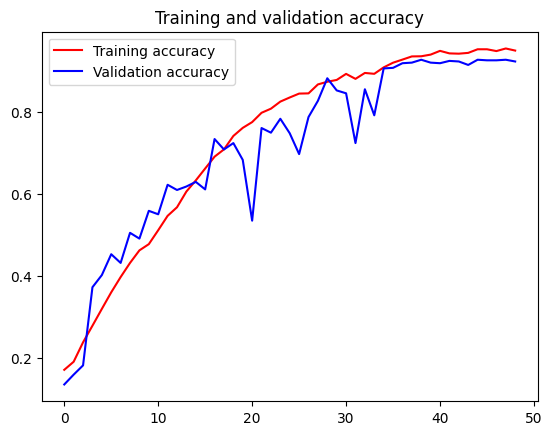

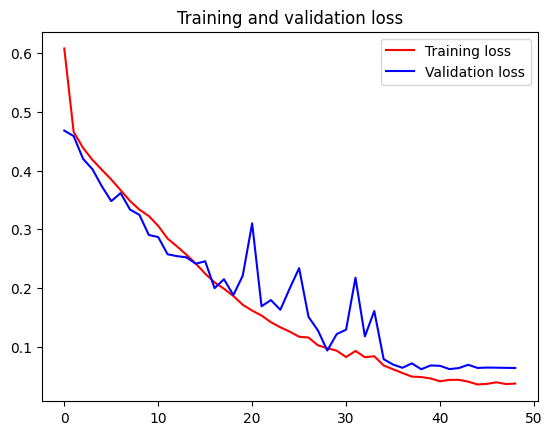

In [21]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.figure()
plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [22]:
# Evaluasi model pada data test
loss, accuracy = model.evaluate(test_generator, verbose=1)
print(f"\n📉 Test Loss     : {loss}")
print(f"✅ Test Accuracy : {accuracy}")

12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 144ms/step - accuracy: 0.9119 - loss: 0.0980

📉 Test Loss     : 0.0988929495215416
✅ Test Accuracy : 0.9047619104385376


12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 260ms/step

📋 Classification Report:
                  precision    recall  f1-score   support

            Audi       0.81      0.92      0.86       102
   Hyundai Creta       0.93      0.91      0.92       102
Mahindra Scorpio       0.96      0.90      0.93       102
     Rolls Royce       0.84      0.86      0.85       102
           Swift       0.97      0.91      0.94       102
     Tata Safari       0.94      0.90      0.92       102
   Toyota Innova       0.91      0.92      0.92       102

        accuracy                           0.90       714
       macro avg       0.91      0.90      0.91       714
    weighted avg       0.91      0.90      0.91       714



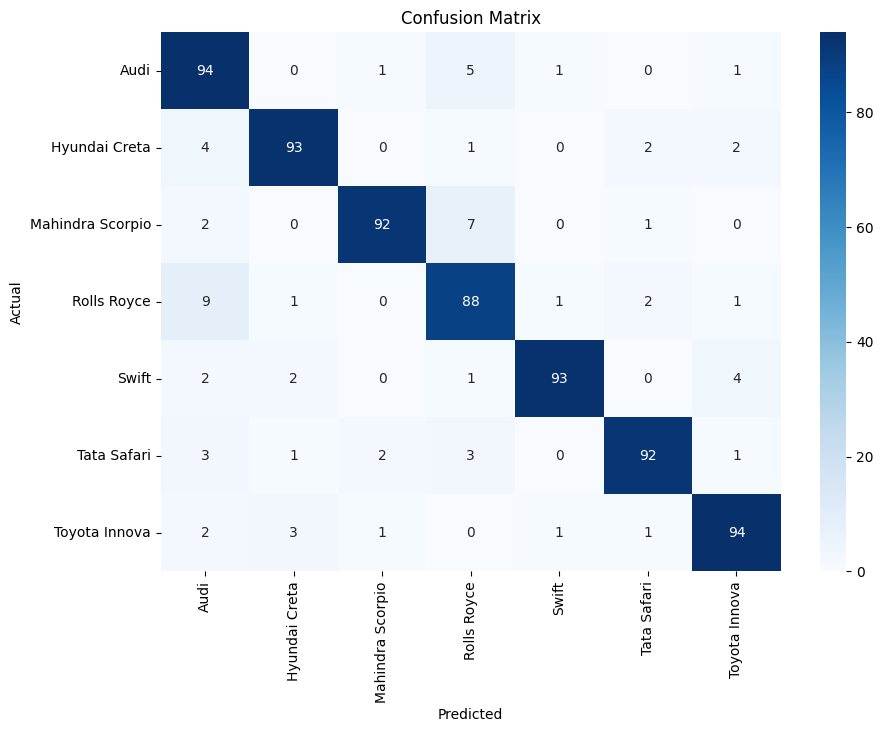

In [32]:
# Prediksi label dari data test
pred_probs = model.predict(test_generator)
y_pred = np.argmax(pred_probs, axis=1)  # Klasifikasi multi-class
y_true = test_generator.classes

# Laporan klasifikasi
print("\n📋 Classification Report:")
class_labels = list(test_generator.class_indices.keys())
print(classification_report(y_true, y_pred, target_names=class_labels))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_labels,
            yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

## Konversi Model

In [34]:
saved_model_dir = '/content/saved_model'
os.makedirs(saved_model_dir, exist_ok=True)

# Simpan model dalam format SavedModel
model.export(saved_model_dir)

assert os.path.exists(os.path.join(saved_model_dir, "saved_model.pb")), "❌ Gagal menyimpan saved_model.pb"
assert os.path.exists(os.path.join(saved_model_dir, "variables")), "❌ Folder 'variables' tidak ditemukan"

print(f"✅ SavedModel berhasil disimpan di: {saved_model_dir}")


Saved artifact at '/content/saved_model'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 150, 150, 3), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 7), dtype=tf.float32, name=None)
Captures:
  134880023458832: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134880022962896: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134879966999376: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134879967000720: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134880022963856: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134879966999952: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134879967001296: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134879967002448: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134879920046928: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134879920047312: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1348799670

In [35]:
os.makedirs("tflite", exist_ok=True)

# Konversi model ke TFLite
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Simpan model TFLite
with open("tflite/model.tflite", "wb") as f:
    f.write(tflite_model)

label_dict = {
    'Audi': 0,
    'Hyundai Creta': 1,
    'Mahindra Scorpio': 2,
    'Rolls Royce': 3,
    'Swift': 4,
    'Tata Safari': 5,
    'Toyota Innova': 6
}

labels = [label for label, index in sorted(label_dict.items(), key=lambda item: item[1])]

with open("tflite/label.txt", "w") as f:
    for label in labels:
        f.write(label + "\n")

Saved artifact at '/tmp/tmpxv0j4tdb'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 150, 150, 3), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 7), dtype=tf.float32, name=None)
Captures:
  134880023458832: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134880022962896: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134879966999376: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134879967000720: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134880022963856: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134879966999952: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134879967001296: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134879967002448: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134879920046928: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134879920047312: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13487996700225

In [36]:
!pip install tensorflowjs

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.1/89.1 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 4.7 MB/s eta 0:00:00
  Attempting uninstall: packaging
    Found existing installation: packaging 24.2
    Uninstalling packaging-24.2:
      Successfully uninstalled packaging-24.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-cloud-bigquery 3.31.0 requires packaging>=24.2.0, but you have packaging 23.2 which is incompatible.


In [37]:
import tensorflowjs as tfjs

saved_model_dir = "/content/saved_model"
tfjs_output_dir = "/content/tfjs_model"

tfjs.converters.convert_tf_saved_model(
    saved_model_dir,
    tfjs_output_dir
)

print(f"✅ Model berhasil dikonversi ke TFJS dan disimpan di: {tfjs_output_dir}")

✅ Model berhasil dikonversi ke TFJS dan disimpan di: /content/tfjs_model


## Inference (Optional)

Isi prediksi: {'output_0': <tf.Tensor: shape=(1, 7), dtype=float32, numpy=
array([[4.4738292e-07, 2.0877647e-07, 5.8662351e-09, 1.4424393e-08,
        1.2403818e-07, 2.1918054e-09, 9.9999917e-01]], dtype=float32)>}
Predicted Class: Toyota Innova
Confidence Score: 100.00%


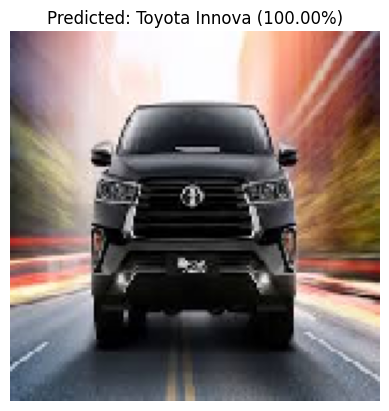

In [38]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image

# Load SavedModel
saved_model_path = '/content/saved_model'
model = tf.saved_model.load(saved_model_path)
infer = model.signatures["serving_default"]

# Daftar label kelas (gunakan list, bukan dict)
class_labels = [
    'Audi',
    'Hyundai Creta',
    'Mahindra Scorpio',
    'Rolls Royce',
    'Swift',
    'Tata Safari',
    'Toyota Innova'
]

# Load dan praproses gambar
img_path = '/content/dataset/Cars Dataset/test/Toyota Innova/585.jpg'
img = image.load_img(img_path, target_size=(150, 150))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array /= 255.0

# Buat tensor input
input_tensor = tf.convert_to_tensor(img_array, dtype=tf.float32)

# Lakukan inferensi
predictions = infer(input_tensor)

# Tampilkan isi prediksi untuk cek key output-nya
print("Isi prediksi:", predictions)

# Ambil key output (biasanya hanya satu key)
output_key = list(predictions.keys())[0]
output_tensor = predictions[output_key].numpy()

# Ambil index prediksi dengan confidence tertinggi
predicted_class_index = np.argmax(output_tensor)
confidence_score = output_tensor[0][predicted_class_index]
confidence_percentage = confidence_score * 100

# Ambil nama kelas
predicted_class = class_labels[predicted_class_index]

# Tampilkan hasil
print(f"Predicted Class: {predicted_class}")
print(f"Confidence Score: {confidence_percentage:.2f}%")

# Visualisasi gambar dan prediksi
plt.imshow(img)
plt.title(f"Predicted: {predicted_class} ({confidence_percentage:.2f}%)")
plt.axis('off')
plt.show()

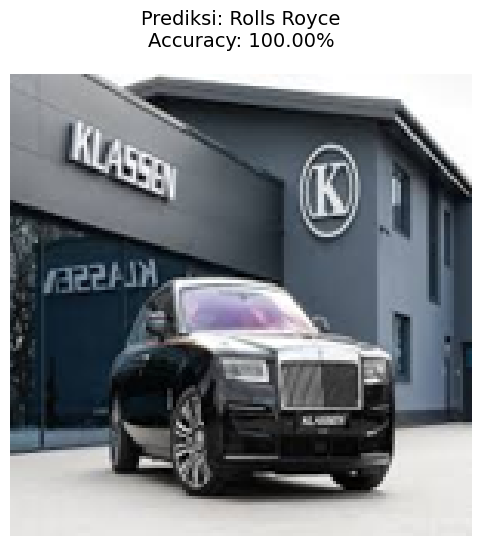


Probabilitas per kelas:
 Audi: 0.00%
 Hyundai Creta: 0.00%
 Mahindra Scorpio: 0.00%
 Rolls Royce: 100.00%
 Swift: 0.00%
 Tata Safari: 0.00%
 Toyota Innova: 0.00%


In [40]:
# Path model TFLite
tflite_model_path = "/content/tflite/model.tflite"

# Load model TFLite
interpreter = tf.lite.Interpreter(model_path=tflite_model_path)
interpreter.allocate_tensors()

# Ambil detail input dan output
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Label sesuai urutan pelatihan
labels = [
    'Audi',
    'Hyundai Creta',
    'Mahindra Scorpio',
    'Rolls Royce',
    'Swift',
    'Tata Safari',
    'Toyota Innova'
]

# Fungsi preprocessing gambar
def preprocess_image(image_path, target_size=(150, 150)):
    img = Image.open(image_path).convert('RGB')
    img = img.resize(target_size)
    img_array = np.array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0).astype(np.float32)
    return img_array, img

# inference untuk satu gambar
image_path = "/content/dataset/Cars Dataset/test/Rolls Royce/114.jpg"
input_data, original_img = preprocess_image(image_path)

# Set input tensor
interpreter.set_tensor(input_details[0]['index'], input_data)

# Jalankan inference
interpreter.invoke()

# Ambil hasil output
output_data = interpreter.get_tensor(output_details[0]['index'])
predicted_index = np.argmax(output_data)
predicted_label = labels[predicted_index]
Accuracy = output_data[0][predicted_index] * 100

# menampilkan gambar dan hasil prediksi
plt.figure(figsize=(8, 6))
plt.imshow(original_img)
plt.title(f"Prediksi: {predicted_label}\nAccuracy: {Accuracy:.2f}%", fontsize=14, pad=20)
plt.axis('off')

plt.show()

print(f"\nProbabilitas per kelas:")
for i, (label, prob) in enumerate(zip(labels, output_data[0])):
    print(f" {label}: {prob*100:.2f}%")

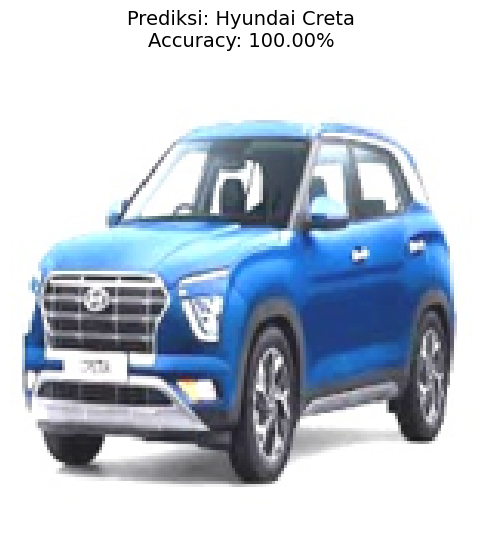


Probabilitas per kelas:
 Audi: 0.00%
 Hyundai Creta: 100.00%
 Mahindra Scorpio: 0.00%
 Rolls Royce: 0.00%
 Swift: 0.00%
 Tata Safari: 0.00%
 Toyota Innova: 0.00%


In [42]:
# Path model TFLite
tflite_model_path = "/content/tflite/model.tflite"

# Load model TFLite
interpreter = tf.lite.Interpreter(model_path=tflite_model_path)
interpreter.allocate_tensors()

# Ambil detail input dan output
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Label sesuai urutan pelatihan
labels = [
    'Audi',
    'Hyundai Creta',
    'Mahindra Scorpio',
    'Rolls Royce',
    'Swift',
    'Tata Safari',
    'Toyota Innova'
]

# Fungsi preprocessing gambar
def preprocess_image(image_path, target_size=(150, 150)):
    img = Image.open(image_path).convert('RGB')
    img = img.resize(target_size)
    img_array = np.array(img) / 255.0  # Normalize pixel values
    img_array = np.expand_dims(img_array, axis=0).astype(np.float32)
    return img_array, img

# Inference untuk satu gambar
image_path = "/content/dataset/augmented/Hyundai Creta/Hyundai Creta_add_brightness_27.jpg"
input_data, original_img = preprocess_image(image_path)

# Set input tensor
interpreter.set_tensor(input_details[0]['index'], input_data)

# Jalankan inference
interpreter.invoke()

# Ambil hasil output
output_data = interpreter.get_tensor(output_details[0]['index'])
predicted_index = np.argmax(output_data)
predicted_label = labels[predicted_index]
Accuracy = output_data[0][predicted_index] * 100

# Menampilkan gambar dan hasil prediksi
plt.figure(figsize=(8, 6))
plt.imshow(original_img)
plt.title(f"Prediksi: {predicted_label}\nAccuracy: {Accuracy:.2f}%", fontsize=14, pad=20)
plt.axis('off')
plt.show()

# Output probabilitas per kelas
print(f"\nProbabilitas per kelas:")
for i, (label, prob) in enumerate(zip(labels, output_data[0])):
    print(f" {label}: {prob*100:.2f}%")


In [44]:
!pip freeze > requirements.txt